[![Google Colab][colab-badge]][colab-url]

[![Deepnote][deepnote-badge]][deepnote-url]

[colab-badge]: https://colab.research.google.com/assets/colab-badge.svg
[colab-url]: https://colab.research.google.com/github/farhanreynaldo/side-project/blob/master/approximate-bayesian-computation.ipynb
[deepnote-badge]: https://beta.deepnote.com/buttons/launch-in-deepnote.svg
[deepnote-url]: https://beta.deepnote.com/launch?template=data-science&url=https%3A//github.com/farhanreynaldo/side-project/blob/master/approximate-bayesian-computation.ipynb

I saw this shower problem first from [**Cameron Davidson-Pilon**'s reply](https://twitter.com/Cmrn_DP/status/1407159305904795658) on [Allen Downey's tweet](https://twitter.com/AllenDowney/status/1406981524524834818). I was hooked to solve the problem using similar approach from Allen's USB connector problem. But later on he posted his approach to the shower problem. The original problem [posted by Chris Said](https://chris-said.io/2020/02/08/the-shower-problem/) stated as follows:

> #### The Shower Problem
>
> Here’s the setup: You’re at your friend’s place and you need to take a shower. The shower knob is unlabeled. One direction is hot and the other direction is cold, and you don’t know which is which.
>
> You turn it to the left. It’s cold. You wait.
>
>At what point do you switch over to the right?
>
> Let’s make this more explicit.
>
> * Your goal is to find a policy that minimizes the expected amount of time it takes to get hot water flowing out of the shower head. To simplify things, assume that the water coming out of the head is either hot or cold, and that the lukewarm transition time is effectively zero.
>
> * You know that the shower has a Time-To-Hot constant called $\tau$. This value is defined as the time it takes for hot water to arrive, assuming you have turned the knob to the hot direction and keep it there.
>
> * The constant is a fixed property of the shower and is sampled once from a known distribution. You have certain knowledge of the distribution, but you don’t know $\tau$.
>
> * The shower is memoryless, such that every time you turn the knob to the hot direction, it will take $\tau$ seconds until the hot water arrives, regardless of your prior actions. Every time you turn it to the cold direction, only cold water will come out.
>
> I don’t know how to solve this problem. But as a starting point I realize it’s possible to keep track of the probability that the hot direction is to the left or to the right. In the animation above, the probability that the hot direction is to the right is just the unexplored white area under the right curve, divided by the total unexplored white area of both curves.
>
> But how do you turn that into a policy for exploring the space? Does anybody know?

In this post, I am going to approach this problem using a simple rule as baseline (or think of this as an "optimized" baseline).

First, let's assume we start from the left direction. After waiting for `t` seconds, the water is still cold. So, we try the right direction and wait longer than our previous waiting time. We switch the direction each time until we passed the Time-To-Hot constant ($\tau$). But, how long should we wait on the next try? Since the author provides the additional information that the distribution of $\tau$ is Weibull with parameters $\lambda=50$ and $k=1.5$, we would sample the additional waiting time from that distribution. Furthermore, our average duration should be reported using the provided [$\tau$ samples](https://gist.github.com/csaid/a57c4ebaa1c7b0671cdc9692638ea4c4).

In [1]:
import os

import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [2]:
shower_url = 'https://gist.github.com/csaid/a57c4ebaa1c7b0671cdc9692638ea4c4/' \
             'raw/ad1709938834d7bc88b62ff0763733502eb6a329/' \
             'shower_problem_tau_samples.csv'

test = pd.read_csv(shower_url)
test.head()

,direction,tau
0,1.0,44.173094
1,1.0,39.133131
2,1.0,2.229446
3,1.0,45.518857
4,1.0,32.463695


The explanation above can be written as the following code, where we keep track on the number of flips and the time elapsed. Initially, we would set the `init_wait` = 0, meaning our waiting time would be equal to the Weibull distribution sample. For illustration purposes, we set the `direction` = 1 and `tau` = 50. 

In [3]:
def simulate(direction, tau, init_wait, lam, k, flips=0, total_time=0):
  samples = stats.weibull_min.rvs(1.5, scale=50, size=1000)

  while True:
    wait = init_wait + samples[flips]
    if direction and tau < wait:
      return flips, total_time + tau
    
    # change direction
    direction = not direction
    init_wait = wait
    total_time += wait
    flips += 1
    
simulate(direction=1, tau=50, init_wait=0, lam=50, k=1.5)

(2, 109.43581339004803)

In [4]:
def run_simulations(df, func, **kwargs):
  res = []
  samples = zip(df['direction'], df['tau'])
  for direction, tau in samples:
    flips, total_time = func(direction, tau, **kwargs)
    res.append((flips, total_time))
  return np.transpose(res)

flips, total_time = run_simulations(test, simulate, init_wait=0, lam=50, k=1.5)
flips.mean(), total_time.mean()

(1.26155, 115.02289345861824)

By running the simulation against the test samples, the average waiting duration is around 115 seconds. Our baseline is lower than the previous solution by Cameron Davidson-Pilon and Allen Downey, 111.4 seconds and 102 seconds respectively.

But, what if we set another value to the `init_wait` parameter? Since we knew the problem followed Weibull distribution, we might try various values between 5% and 95% percentile. We should also simulate against a train set, which we would create later, to find the optimal `init_wait`.

In [5]:
train = test.copy().sample(1000)
train['tau'] = stats.weibull_min.rvs(1.5, scale=50, size=len(train))

low, high = stats.weibull_min.ppf([0.05, 0.95], 1.5, scale=50).astype(int)
init_waits = list(range(low, high))

time = []
for init_wait in tqdm(init_waits):
  flips, total_time = run_simulations(train, simulate, init_wait=init_wait, lam=50, k=1.5)
  time.append(total_time.mean())

100%|██████████| 97/97 [00:18<00:00,  5.30it/s]


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


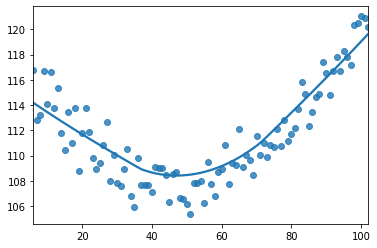

In [6]:
sns.regplot(x=init_waits, y=time, lowess=True);

Based on the plot above, the optimal value is around 45. Let's simulate the test set using our new `init_wait`.

In [7]:
flips, total_time = run_simulations(test, simulate, init_wait=45, lam=50, k=1.5)
flips.mean(), total_time.mean()

(0.69345, 109.4372895617304)

In conclusion, the average duration for the optimal baseline is around 108 seconds. In the future post, we might look into another strategy to minimize the average duration.